# Assignment 2: Question 4

Import modules and data:

In [1]:
import pandas as pd
import os
import numpy as np
import sympy as sym
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import logit
from scipy.stats import norm
import math
import decimal

df = pd.read_csv('datamerged2.csv')

Select only observations from Treatment 1:

In [2]:
df = df[df['treatment']==1]
df.describe()

,id,treatment,tofrom,value,role,resp,round,rounds,old
count,768.000000,768.0,768.000000,768.000000,768.0,768.000000,768.000000,768.000000,768.000000
mean,121.414062,1.0,132.058594,20.273151,0.0,0.776042,1.647135,2.292969,0.852865
std,84.363375,0.0,88.298256,7.573855,0.0,0.417166,0.651319,0.455421,0.706068
min,1.000000,1.0,6.000000,0.000000,0.0,0.000000,1.000000,2.000000,0.000000
25%,23.500000,1.0,26.750000,15.000000,0.0,1.000000,1.000000,2.000000,0.000000
50%,137.000000,1.0,149.000000,20.000000,0.0,1.000000,2.000000,2.000000,1.000000
75%,162.000000,1.0,177.000000,25.000000,0.0,1.000000,2.000000,3.000000,1.000000
max,250.000000,1.0,274.000000,49.000000,0.0,1.000000,3.000000,3.000000,2.000000


The goal is to estimate the empirical probability with which a given offer will be accepted.

First, lets plot histograms of all offers made and those which were accepted:

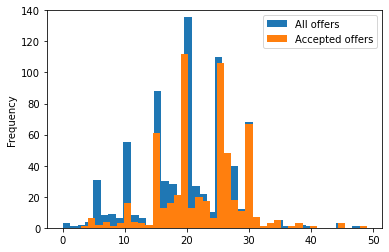

In [3]:
histplot = df['value'].plot.hist(bins=40,ylim=(0,140))

df_accepted = df[df['resp']==1]
df_accepted['value'].plot.hist(bins=40,ylim=(0,140))
histplot.legend(["All offers","Accepted offers"])

Eyeballing this, it appears as though the large majority of offers above about $22 are accepted, while offers below this are less and less frequently accepted as value decreases.

## Attempt 1
First, I will model accept/reject behaviour according to a logit model, where probability of acceptance is a function of the offer.

In [4]:
model_1 = logit("resp ~ value",df).fit()
print(model_1.summary())

Optimization terminated successfully.
         Current function value: 0.386547
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                   resp   No. Observations:                  768
Model:                          Logit   Df Residuals:                      766
Method:                           MLE   Df Model:                            1
Date:                Fri, 12 Mar 2021   Pseudo R-squ.:                  0.2732
Time:                        20:47:28   Log-Likelihood:                -296.87
converged:                       True   LL-Null:                       -408.48
Covariance Type:            nonrobust   LLR p-value:                 1.794e-50
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.4743      0.298     -8.307      0.000      -3.058      -1.890
value          0.2095      0.

In [5]:
mfx = model_1.get_margeff()
print(mfx.summary())

        Logit Marginal Effects       
Dep. Variable:                   resp
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
value          0.0254      0.001     19.749      0.000       0.023       0.028


Our logit model suggests that on the margin, a $1 increase in the offered value increases likelihood of acceptance by 2.5%

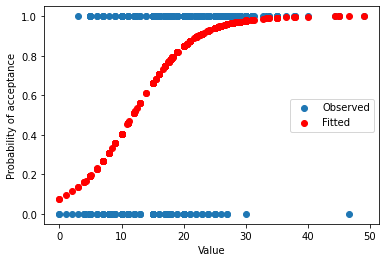

In [6]:
df['predictions'] = model_1.predict()
plt.scatter(df['value'],df['resp'])
plt.scatter(df['value'],df['predictions'],c='red')
plt.legend(["Observed","Fitted"])
plt.xlabel("Value")
plt.ylabel("Probability of acceptance")
plt.show()


(Here I could add a section to test predictive power of this logit vs probit using data from Treatment 2)

Next, I model utility for the proposer using a loss aversion framework:

$$U(x,\lambda,r) = \left\{
\begin{array}{ll}
      x-r & x\geq r \\
      \lambda(x-r) & x<r \\
\end{array} 
\right.  $$

Where $x$ is the value which the proposer receives, and $r$ is a reference offer assumed to be the minimum amount that the proposer believes would be accepted with certainty. $\lambda \geq 1$ is a measure of risk aversion. Risk aversion is decreasing in $\lambda$, and a value of $1$ implies no risk aversion.

Let $Q(s)$ be the probability with which a proposer believes an offer $s$ will be accepted, where $s = 55-x$. Then each proposer maximizes:

$$\max_{s} Q(s)(55-s-r) - (1-Q(s))\lambda r$$

The logit model is of the form $$ln\frac{Q(s)}{1-Q(s)} = \beta_0 + \beta_1 s$$

With some algebra, $$Q(s) = \frac{1}{1+e^{-(\beta_0 + \beta_1 s)}}$$

i.e. the sigmoid function.

The FOC for proposers gives: $$Q'(s)(55-s-r) - Q(s) + Q'(s) \lambda r = 0 $$

Lets simplify this using some symbolic programming.

In [7]:
s, b0, b1, lam, r = sym.symbols("s b0 b1 lam r")


Q = sym.Function("Q")(s,b0,b1)
Q = 1/(1+sym.exp(-b0-b1*s))
Q_s = sym.Function("Q_s")
Q_s = sym.diff(Q,s)

eq = Q*(55-s-r) - (1-Q)*lam*r

lam_func = sym.solve(sym.diff(eq,s),lam)[0]
lam_func

(b1*r + b1*s - 55*b1 + exp(b0 + b1*s) + 1)/(b1*r)

The above function gives the implied loss aversion $\lambda$ for each offerer, given the observed offer $s$, and the parameters $r$, $\beta_0$, and $\beta_1$.

This is a function which gives the optimal offer for an individual given their $\lambda$, and the parameters $r$, $\beta_0$, and $\beta_1$. Following the github document, I will take $r$ to be 1/2 of the total value available:

In [8]:
r_proposer = 55/2

We now have parameters for our simple model, which will give us an empirical estimate for the distribution of lambdas once we plug in the offers $s$ submitted by each proposer:

0.9739583333333334


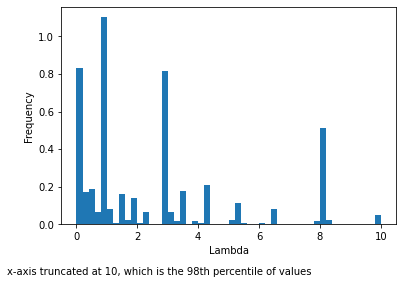

In [10]:
lam_implied = []
for i in df['value']:
    lam_implied.append(lam_func.subs([(r,r_proposer),(b0,model_1.params[0]),(b1,model_1.params[1]),(s,i)]))
lam_implied
# Need to limit the histogram axes, so calculate the share of implied lambdas which are below 10:
lam_implied = np.array(lam_implied, dtype=float)
percentile = sum(i > 10 for i in lam_implied)/lam_implied.size
print(1-percentile)

# Plot
plt.hist(lam_implied,density=True,range=[0,10],bins=50)
plt.xlabel("Lambda")
plt.ylabel("Frequency")
plt.figtext(0,-0.05,"x-axis truncated at 10, which is the 98th percentile of values")
plt.show()


Lets fit a parametric distribution to this data. 

To me, the shape looks vaguely like a log-normal distribution. Many human behaviours follow log-normal distributions, so it is at least plausible.

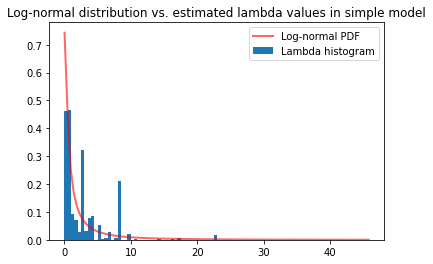

In [11]:
shape, loc, scale = stats.lognorm.fit(lam_implied[lam_implied>0], floc=0) # hold location to 0 while fitting
np.log(scale), shape  # mu, sigma

x = np.linspace(stats.lognorm.ppf(0.01, shape),
                stats.lognorm.ppf(0.99, shape), 100)
plt.hist(lam_implied,density=True,range=[0,25],bins=50)
plt.plot(x, stats.lognorm.pdf(x, shape),
       'r-', lw=2, alpha=0.6, label='lognorm pdf')
plt.legend(["Log-normal PDF","Lambda histogram"])
plt.title("Log-normal distribution vs. estimated lambda values in simple model")
plt.show()

Technically, we now have parametric estimates for both probability of accepting an offer, Q, and for distribution of loss aversion parameters, G.

Unfortunately, we have a very poor fit, especially given the assumption that lambda should be above 1. \
55% of the estimated lambda values are less than 1:

In [12]:
percentile = sum(i < 1 for i in lam_implied)/lam_implied.size
print(percentile)

0.5520833333333334


## Attempt 2
Let's try to improve upon the first attempt by adding the spitefulness and competitiveness factors suggested in the github notebook.

This time I will also normalize all values to the range [0,1], so that values represent shares.

In [13]:
df_norm = df
df_norm['value'] = df_norm['value']/55

Spitefulness will decrease payoffs for proposers when the other player gets a larger share. For simplicity, assume this is a fixed cost, as in the notebook. Competitiveness is a linear function in the difference between the value which the proposer obtains and the value obtained by the responder.

Now, we have the utility function:

$$V(x,y,\lambda,r) = \left\{
\begin{array}{ll}
      x-r-\frac{1}{2} & 0\leq x < y; s \geq r \\
      \lambda(x-r)-\frac{1}{2} & 0<x<y; s<r \\
      x-r+\alpha(x-y) & x \geq y; x \geq r \\
      \lambda(x-r) + \alpha(x-y) & x \geq y; x<r\\
      -\lambda r & x=y=0 \\
\end{array} 
\right.  $$

Where $x$ is the value obtained by the proposer, $y$ is the value obtained by the responder, $s$ is the amount offered, $r$ is the reference offer, $\lambda$ is the loss-aversion parameter, and $\alpha$ is the competitiveness parameter, which is assumed to be positive and constant across individuals.

Now, the proposer would like to maximise the function:

$$Q(s)((1-s) + \alpha(1-2s)) - (1-Q(s))\lambda r$$

Solving using symbolic programming:

In [14]:
a=sym.symbols("a")

eq2 = Q*((1-s) + a*(1-2*s)) - (1-Q)*lam*r
lam_func2 = sym.solve(sym.diff(eq2,s),lam)[0]
lam_func2

(2*a*b1*s - a*b1 + 2*a*exp(b0 + b1*s) + 2*a + b1*s - b1 + exp(b0 + b1*s) + 1)/(b1*r)

As above, this expression gives the lambda which is associated with a utility maximizing offer $s$, given the individual's competitiveness parameter, $\alpha$ (labeled "a" in the above equation). However, now that we have the additional parameter $\alpha$ to estimate, we cannot simply back out $\lambda$ as before.

In order to have enough information to estimate all of the parameters, we need to make some changes. Specifically, we need to change the assumption that responders follow a logit model with no loss aversion. We can gain the necessary information by including a loss aversion parameter in the responder decision making process, and assuming that it is distributed according to the same distribution as it is for proposers. This will produce an equilibrium which can be solved by finding the right $\alpha$.

Assume now that responders also follow the same payoff function $V(x,y,\lambda,r)$ as described above.

Now, a responder will accept an offer $s$ when $r < s < \frac{1}{2}$ (assuming $r<\frac{1}{2}$) if $$s-r-\frac{1}{2} \geq -\lambda r$$ i.e.

$$\lambda \geq \frac{r-s+\frac{1}{2}}{r}$$

Thus the probability $Q(s)$ that a proposer's offer $s \geq r$ is accepted is:

$$1-G\left( \frac{r-s+\frac{1}{2}}{r} \right)$$

Where $G$ is the distribution of $\lambda$ parameters.

If the offer $s$ is less than $r$, the offer will be accepted if $$\lambda(s-r)-\frac{1}{2} \geq -\lambda r$$ i.e.

$$\lambda \geq \frac{1}{2s}$$

We can think of the function $Q$ as a budget set; proposers choose a bundle of probability of acceptance $\tilde{Q}$ and the amount they give away as an offer $\tilde{s}$ somewhere along the function given by $Q$. They will do this by equating their MRS between these two goods (i.e. the slope of their iso-utility curve) with the slope of the budget line. 

Thus, proposers must solve:

$$\max_{\tilde{Q},\tilde{s}} \tilde{Q}((1-\tilde{s}) + \alpha(1-2 \tilde{s})) - (1-\tilde{Q}))\lambda r$$ subject to $Q(\tilde{s},r) = \tilde{Q}$

Solving the system of equations given by the FOCs:


In [15]:
Q_d, s_t = sym.symbols("Q_d s_t") 
Q_t = sym.Function("Q_t")(s_t)

eq3 = Q_t*(1-s_t+a*(1-2*s_t)) - (1-Q_t)*lam*r #(my eq)
eq4 = Q_t*(1-s_t*(1+2*a)+a-(1/2)) - (1-Q_t)*lam*r # as written in the jupyter notebook. I think this is wrong?

sym.solve(sym.diff(eq3,Q_t) - sym.diff(eq3,s_t),lam)[0]
#sym.solve(sym.diff(eq4,Q_t) - sym.diff(eq4,s_t),lam)[0]

#isoslope = (Q_t*(1+(2*a)))/((1+a)-(s_t*(1+(2*a)))+r*(lam-1))

#isoslope = (Q_t*(1+(2*a)))/((1 - s_t*(1+2*a) + a) + ((lam-1)/2))
#lam_implied = sym.solve(isoslope-Q_d,lam)[0]
#lam_implied

(2*a*s_t*Derivative(Q_t(s_t), s_t) - 2*a*s_t + 2*a*Q_t(s_t) - a*Derivative(Q_t(s_t), s_t) + a + s_t*Derivative(Q_t(s_t), s_t) - s_t + Q_t(s_t) - Derivative(Q_t(s_t), s_t) + 1)/(r*(Derivative(Q_t(s_t), s_t) - 1))

Where $Q_d$ refers to $Q'(s)$; $Q_t$ refers to $\tilde{Q}$; and $s_t$ refers to $\tilde{s}$.

The above equation simplifies to $$\lambda = \frac{2 r \tilde{Q}(s) (1+2\alpha)}{Q'(s)} - 2(1-s(1+2\alpha)) + 1$$

Now we're back in a similar position to where we were before we made the switch to responders having loss aversion and competitiveness; the difference is that we now have an additional piece of information: since lambdas come from the same distribution for both proposers and responders, we can use the equilibrium condition
$$\hat{Q}(s) = 1-\hat{G}\left(\frac{r-s+\frac{1}{2}}{r}\right)$$

In addition, recognize that our empirically observed offers $\psi(s)$ can be expressed as 

$$\psi(s) = \hat{G}\left(\frac{2 r Q(s) (1+2\alpha)}{Q'(s)} - 2(1-s(1+2\alpha)) + 1\right)$$

Now we can use our logit output as an estimate for $\hat{Q}(s)$, and we just need to find the parameter $\alpha$ which solves these two equations.


Lets begin with $\hat{Q}(s)$. We need to re-estimate our logit model using the normalized data:


Optimization terminated successfully.
         Current function value: 0.386547
         Iterations 7


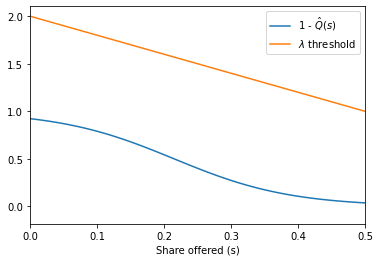

In [73]:
r_proposer = 1/2
model_2 = logit("resp ~ value",df_norm).fit()

df_fit = pd.DataFrame()
df_fit['value'] = [x / 100.0 for x in range(0, 105, 1)]
df_fit['Q_hat'] = model_2.predict(df_fit['value'])
df_fit['lam_thresh'] = (r_proposer - df_fit['value'] + 0.5)/r_proposer

plt.plot(df_fit['value'],1 - df_fit['Q_hat'])
plt.plot(df_fit['value'],df_fit['lam_thresh'])
plt.legend(["1 - $\hat{Q}(s)$","$\lambda$ threshold"])
plt.xlim([0,0.5])
plt.xlabel("Share offered (s)")
plt.show()

The blue line in the above plot is the probability with which an offer is rejected; this should be equal to $\hat{G}(\lambda$ threshold$)$ for each offer $s$. The chart is cut off at $s=0.5$, since $\lambda \geq 1$ and a responder with no loss aversion (i.e. $\lambda = 1$) will always accept any offer greater than 1. 

Suppose $\lambda$ is distributed uniformly from 1 to 2, i.e. $G = U(1,2)$. This appears to be a good rough approximation for our responders:

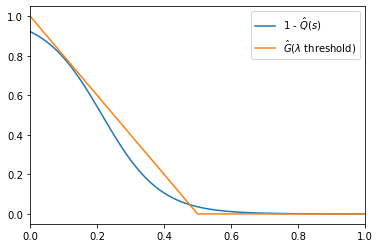

In [475]:
def G_hat_U(lam,l,h):
    if lam<=l:
        return 0
    elif lam>=h:
        return 1
    else:
        return((lam-1)/(h-l))

df_fit['G_hat_imputed'] = df_fit.apply(lambda x: G_hat_U(x['lam_thresh'],1,2), axis=1)

plt.plot(df_fit['value'],1 - df_fit['Q_hat'])
plt.plot(df_fit['value'],df_fit['G_hat_imputed'])
plt.legend(["1 - $\hat{Q}(s)$","$\hat{G}(\lambda$ threshold)"])
plt.xlim([0,1])
plt.show()

We could do even better by choosing $G \sim N(\mu,\sigma)$. As a first pass, optimizing by trial and error finds that $\mu = 1.56$ and $\sigma = 0.29$ appears to fit well.

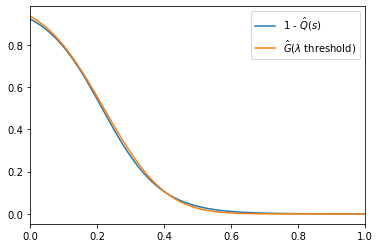

In [480]:
def G_hat_norm(lam,mu,sigma):
    return norm.cdf(lam,loc=mu,scale=sigma)

mu = 1.56
sigma = 0.29

df_fit['G_hat_imputed'] = df_fit.apply(lambda x: G_hat_norm(x['lam_thresh'],mu,sigma), axis=1)

plt.plot(df_fit['value'],1 - df_fit['Q_hat'])
plt.plot(df_fit['value'],df_fit['G_hat_imputed'])
plt.legend(["1 - $\hat{Q}(s)$","$\hat{G}(\lambda$ threshold)"])
plt.xlim([0,1])
plt.show()


Of course, hand picking the parameters for $G$'s distribution is not the correct way to do it. Instead, we can minimize the euclidean distance between $\hat{Q}(s)$ and $1-\hat{G}(\lambda)$

In [499]:
mu_list = list(range(0,51))
sigma_list = list(range(0,101))

SSE = np.zeros((len(mu_list),len(sigma_list)))


for i in mu_list:
    for j in sigma_list:
        mu = i/100 + 1.25
        sigma = j/100
        df_fit['G_hat_imputed'] = df_fit.apply(lambda x: G_hat_norm(x['lam_thresh'],mu,sigma), axis=1)
        SSE[i][j] = sum(((1-df_fit['Q_hat'])-df_fit['G_hat_imputed'])**2)
        

/Users/lukefrymire/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1844: RuntimeWarning: divide by zero encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/lukefrymire/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1844: RuntimeWarning: invalid value encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)


In [500]:
indices = np.unravel_index(np.nanargmin(SSE),(len(mu_list),len(sigma_list)))
SSE[indices]

mu = indices[0]/100+1.25
sigma = indices[1]/100
print("mu = ",mu," sigma = ",sigma)

mu =  1.57  sigma =  0.29


Pretty close!

Now, we need to find an $\alpha$ which gives a good fit with our presumed distribution $G$, and which produces plausible lambda values (i.e., $\lambda \geq 1$). Here, I create a function which gives me the $\lambda$ implied by a given offer $s$ and parameter $\alpha$:

In [501]:
# Get the marginal effect of s on the probability of acceptance, i.e. Q'(s)
df_margfx = pd.concat([df_norm['value'].reset_index(drop=True),pd.DataFrame(model_2.get_margeff(at='all').margeff)],axis=1)
df_margfx = df_margfx.rename(columns={0:"margfx"})

# Estimate probability of acceptance for the normalized offers
df_norm['Q_hat'] = model_2.predict(df_norm['value'])


# Functions to calculate the value of lambda associated with a given s and alpha
def Q(s):
    return df_norm['Q_hat'][df_norm['value']==s].drop_duplicates().item()

def Q_d(s):
    return df_margfx['margfx'][df_margfx['value']==s].drop_duplicates().item()

def lam_s(s,a):
    return(2*r_proposer*Q(s)*(1+2*a)/Q_d(s))-2*(1-s*(1+2*a))+1


# Create a dataframe with only non-duplicate offers
df_nodups = df_norm['value'].drop_duplicates()
df_nodups = df_nodups.reset_index()['value']

Lets plot these to see what they look like for given $\alpha$ values:

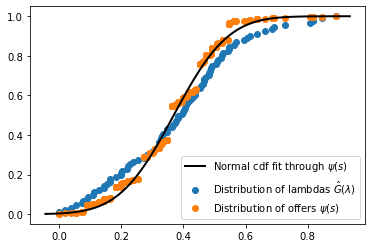

In [502]:
# Try alpha = 2
alpha = 2

# Calculate lambdas associated with each unique offer for given alpha
a1 = []
for i in df_nodups:
    a1.append(lam_s(i,alpha))

# Clean data into usable format
df_a1 = pd.concat([df_nodups.reset_index(drop=True),pd.DataFrame(a1)],axis=1)
df_a1 = df_a1.rename(columns={0:'lam_s'})


# Calculate share of lambdas less or equal to each imputed lambda
lam_cdf = []
for i in df_a1['lam_s']:
    lam_cdf.append(len(df_a1['lam_s'][df_a1['lam_s']<=i])/len(df_a1['lam_s']))

G_hat_implied = pd.DataFrame(lam_cdf)
plt.scatter(df_a1['value'],G_hat_implied)

s_cdf = []
for i in df_norm['value']:
    s_cdf.append(len(df_norm['value'][df_norm['value']<=i])/len(df_norm['value']))
psi_implied = pd.DataFrame(s_cdf)
plt.scatter(df_norm['value'],psi_implied)


# Fit a normal cdf curve to the distribution of actual offers, i.e. psi(s)
mu, std = norm.fit(df_norm['value'])

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.cdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

plt.legend(["Normal cdf fit through $\psi(s)$","Distribution of lambdas $\hat{G}(\lambda)$","Distribution of offers $\psi(s)$"])
plt.show()

In fact, it turns out that the empirical distribution of imputed lambdas does not depend on $\alpha$, since $\lambda(s)$ is monotonically increasing in $s$ for any positive $\alpha$. $\alpha$ does affect the absolute level of $\lambda$, just not comparative levels.

At this point, we have an empirical distribution $\hat{G}(\lambda)$ which appears roughly consistent with both proposers and responders. Both sides are driven by the choice to model the probability of acceptance as a logit function. 

$\alpha=2$ gives the lowest values of $\lambda$ such that none are less than zero. We could try to select $\alpha$ such that $\lambda=1$ is associated with an offer of $r$, but since there are offers above 1/2, this would produce imputed lambdas of less than 1. Alternatively, we could choose $r$ to be the highest value offered, though this doesn't completely jive with the fact that there is only one rejection above $30.